# CVT annual report probability visualisation
This notebook loads the CVT annual report BERT outputs, combines them with a year column, and plots trends of how often each label is predicted strongly across multiple thresholds. Place the yearly files in `CVTdata/` before running.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "CVT"

data_dir = Path("CVTdata")
csv_paths = sorted(data_dir.glob(f"preds-CVT*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('CVTdata/preds-CVT2010.csv'),
 PosixPath('CVTdata/preds-CVT2011.csv'),
 PosixPath('CVTdata/preds-CVT2012.csv'),
 PosixPath('CVTdata/preds-CVT2013.csv'),
 PosixPath('CVTdata/preds-CVT2014.csv'),
 PosixPath('CVTdata/preds-CVT2015.csv'),
 PosixPath('CVTdata/preds-CVT2016.csv'),
 PosixPath('CVTdata/preds-CVT2017.csv'),
 PosixPath('CVTdata/preds-CVT2018.csv'),
 PosixPath('CVTdata/preds-CVT2019.csv'),
 PosixPath('CVTdata/preds-CVT2020.csv'),
 PosixPath('CVTdata/preds-CVT2021.csv'),
 PosixPath('CVTdata/preds-CVT2022.csv'),
 PosixPath('CVTdata/preds-CVT2023.csv'),
 PosixPath('CVTdata/preds-CVT2024.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    if not paths:
        raise FileNotFoundError(f"No CSVs found for pattern preds-{CODE_PREFIX}*.csv in {data_dir}")
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


sentence  \
0      1 Step Inside Nature The Science Behind Retail The Natural Health Industry Recession proof or global high achiever?   
1                           Derma Sciences Our Products get a Fresh New Look Annual Report 2010 Claude Stratford 100 YEARS   
2                                                                   2 Enhance your inner balance with the power of nature.   
3  We harness the power of nature, bringing you high performance ingredients in a pure and powerful form to support you...   
4                                                              CLAUDE STRATFORD 100 YEARS 04. 5 YEAR FINANCIAL SUMMARY 05.   

   source_page source_pdf  prob_fin_label  prob_soc_label  prob_env_label  \
0            1    CVT2010        0.003479        0.004049        0.999018   
1            1    CVT2010        0.001348        0.034630        0.996313   
2            2    CVT2010        0.003018        0.003810        0.999417   
3            2    CVT2010        0.000862        0.996540        0.703644   
4            3    CVT2010        0.003142        0.009999        0.988852   

   prob_maori_label  year  word_count  
0          0.001541  2010          18  
1          0.000949  2010          16  
2          0.002255  2010          10  
3          0.004554  2010          24  
4          0.000816  2010          10

In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


year  prob_fin_label  prob_soc_label  prob_env_label  \
count  8292.000000     8292.000000     8292.000000     8292.000000   
mean   2018.707670        0.420470        0.379151        0.198710   
std       4.711959        0.456519        0.445113        0.356869   
min    2010.000000        0.000184        0.000052        0.000054   
25%    2015.000000        0.005310        0.003056        0.001757   
50%    2020.000000        0.098539        0.044132        0.004212   
75%    2023.000000        0.997156        0.981212        0.171198   
max    2024.000000        0.999662        0.999340        0.999626   

       prob_maori_label  
count       8292.000000  
mean           0.055860  
std            0.207256  
min            0.000061  
25%            0.001084  
50%            0.002063  
75%            0.003599  
max            0.999334

In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


year  word_count label  probability
0  2010          18   FIN     0.003479
1  2010          16   FIN     0.001348
2  2010          10   FIN     0.003018
3  2010          24   FIN     0.000862
4  2010          10   FIN     0.003142

In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
BASE_YEAR = 2018

def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )

    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean() if (s > threshold).any() else 0.0),
            sum_prob_over=("probability", lambda s: s[s > threshold].sum()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["theme_rate_per_1000_words"] = np.where(
        agg["total_words"] > 0,
        (agg["over_count"] / agg["total_words"]) * 1000,
        0.0,
    )
    non_theme = agg["total_sentences"] - agg["over_count"]
    agg["theme_ratio_per_1000_sentences"] = np.where(
        non_theme > 0,
        (agg["over_count"] / non_theme) * 1000,
        0.0,
    )
    base_counts = agg["label"].map(
        agg.loc[agg["year"] == BASE_YEAR, ["label", "over_count"]]
        .drop_duplicates(subset=["label"])
        .set_index("label")["over_count"]
    )
    agg["theme_index_base"] = np.where(
        base_counts > 0,
        (agg["over_count"] / base_counts) * 100,
        0.0,
    )
    agg["avg_theme_score_relevant"] = agg["mean_prob_over"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the first threshold summary
preview_threshold = thresholds[0]
summaries[preview_threshold].head()


year  label  total_sentences  total_words  over_count  over_share  \
0  2010    ENV              438        10686          69    0.157534   
1  2010    FIN              438        10686         158    0.360731   
2  2010  MAORI              438        10686          11    0.025114   
3  2010    SOC              438        10686         176    0.401826   
4  2011    ENV              712        19176         145    0.203652   

   over_word_count  mean_prob_over  sum_prob_over  page_count  \
0             1573        0.971455      67.030421          32   
1             3838        0.980787     154.964386          32   
2              319        0.949176      10.440936          32   
3             4408        0.971065     170.907362          32   
4             4472        0.927621     134.505104          84   

   over_sentence_word_share  over_word_share  sentences_per_page  \
0                  0.006457         0.147202            13.68750   
1                  0.014786         0.359162            13.68750   
2                  0.001029         0.029852            13.68750   
3                  0.016470         0.412502            13.68750   
4                  0.007562         0.233208             8.47619   

   over_sentences_per_page  over_words_per_page  theme_rate_per_1000_words  \
0                  2.15625            49.156250                   6.457047   
1                  4.93750           119.937500                  14.785701   
2                  0.34375             9.968750                   1.029384   
3                  5.50000           137.750000                  16.470148   
4                  1.72619            53.238095                   7.561535   

   theme_ratio_per_1000_sentences  theme_index_base  avg_theme_score_relevant  \
0                      186.991870        230.000000                  0.971455   
1                      564.285714        112.857143                  0.980787   
2                       25.761124        183.333333                  0.949176   
3                      671.755725        151.724138                  0.971065   
4                      255.731922        483.333333                  0.927621   

   threshold  
0        0.7  
1        0.7  
2        0.7  
3        0.7  
4        0.7

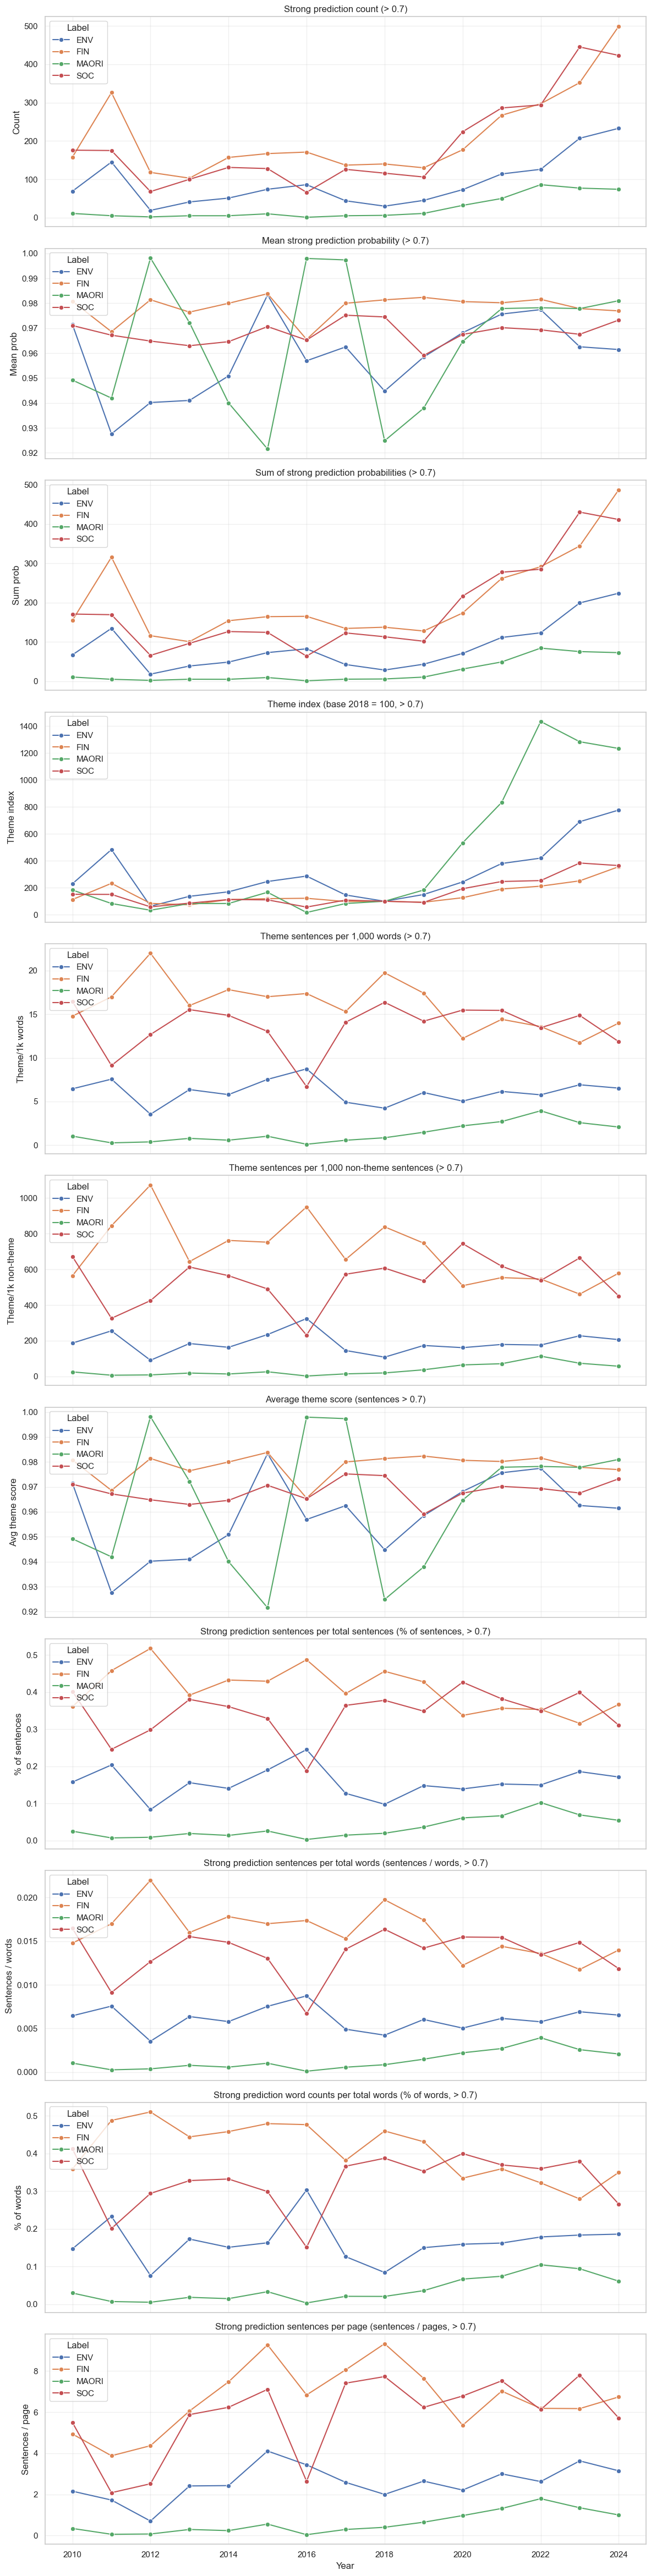

In [7]:
# Combined view for threshold > 0.7 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.7)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.7)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.7)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.7)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.7)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.7)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.7)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.7)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.7)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.7)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.7)"),
]
summary = summaries[0.7]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


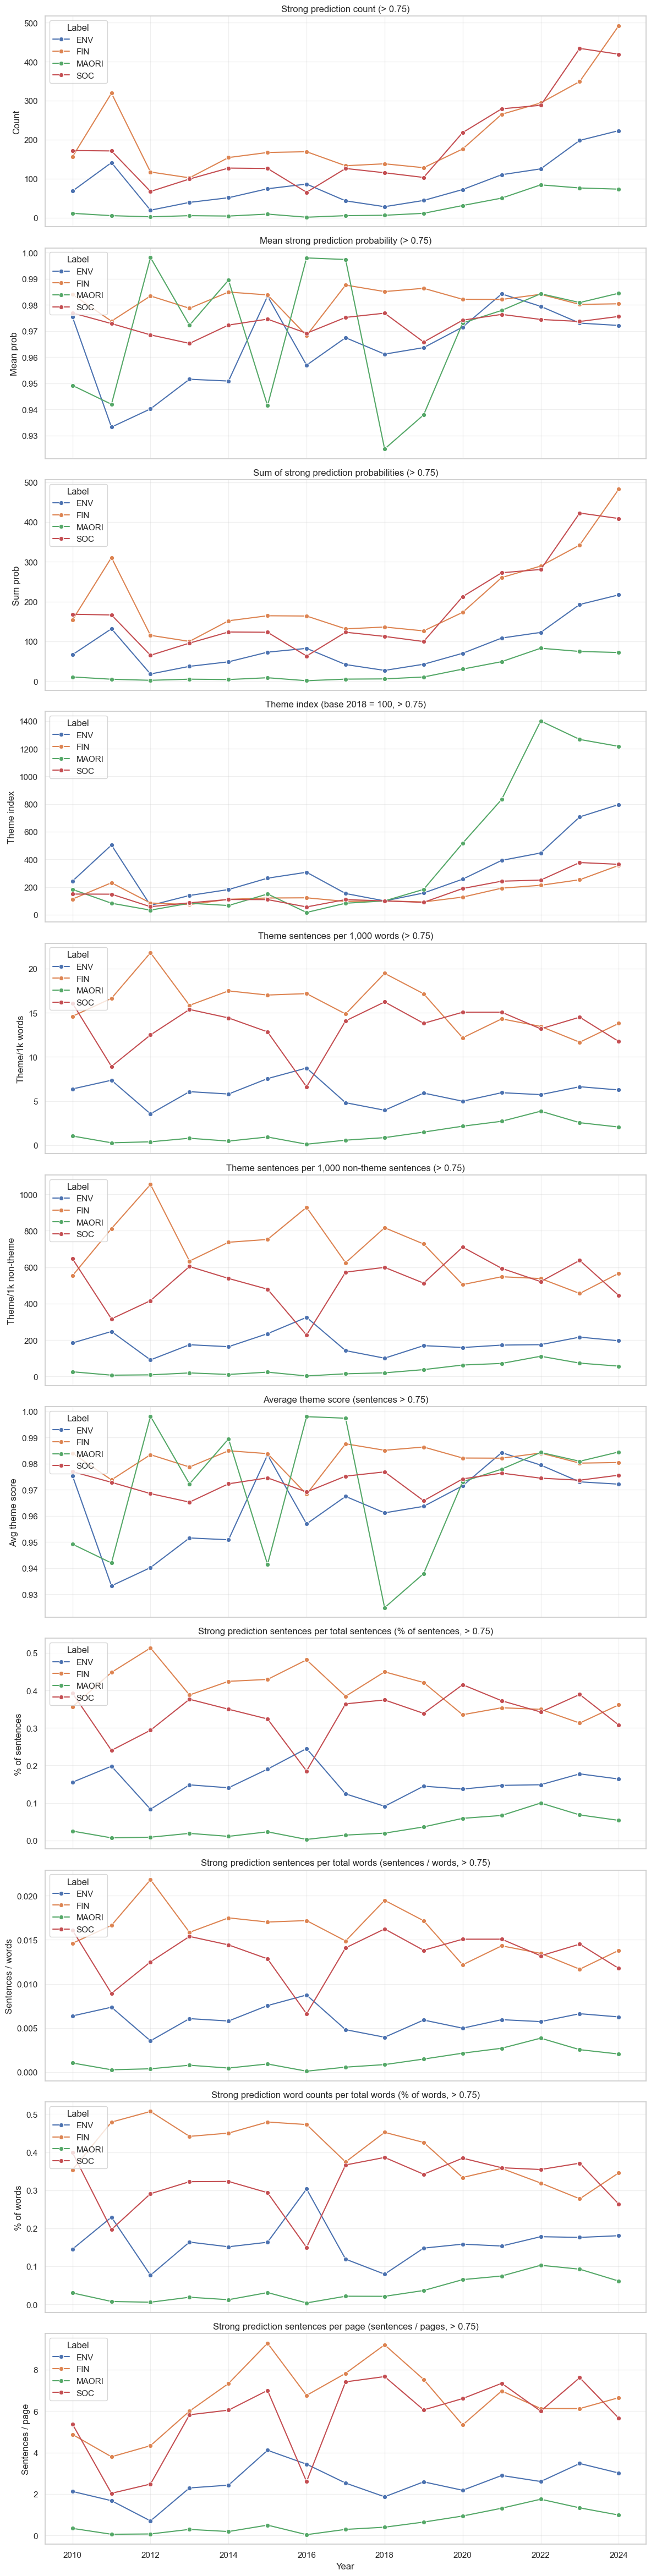

In [8]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.75)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.75)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.75)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.75)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.75)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.75)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.75)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.75)"),
]
summary = summaries[0.75]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


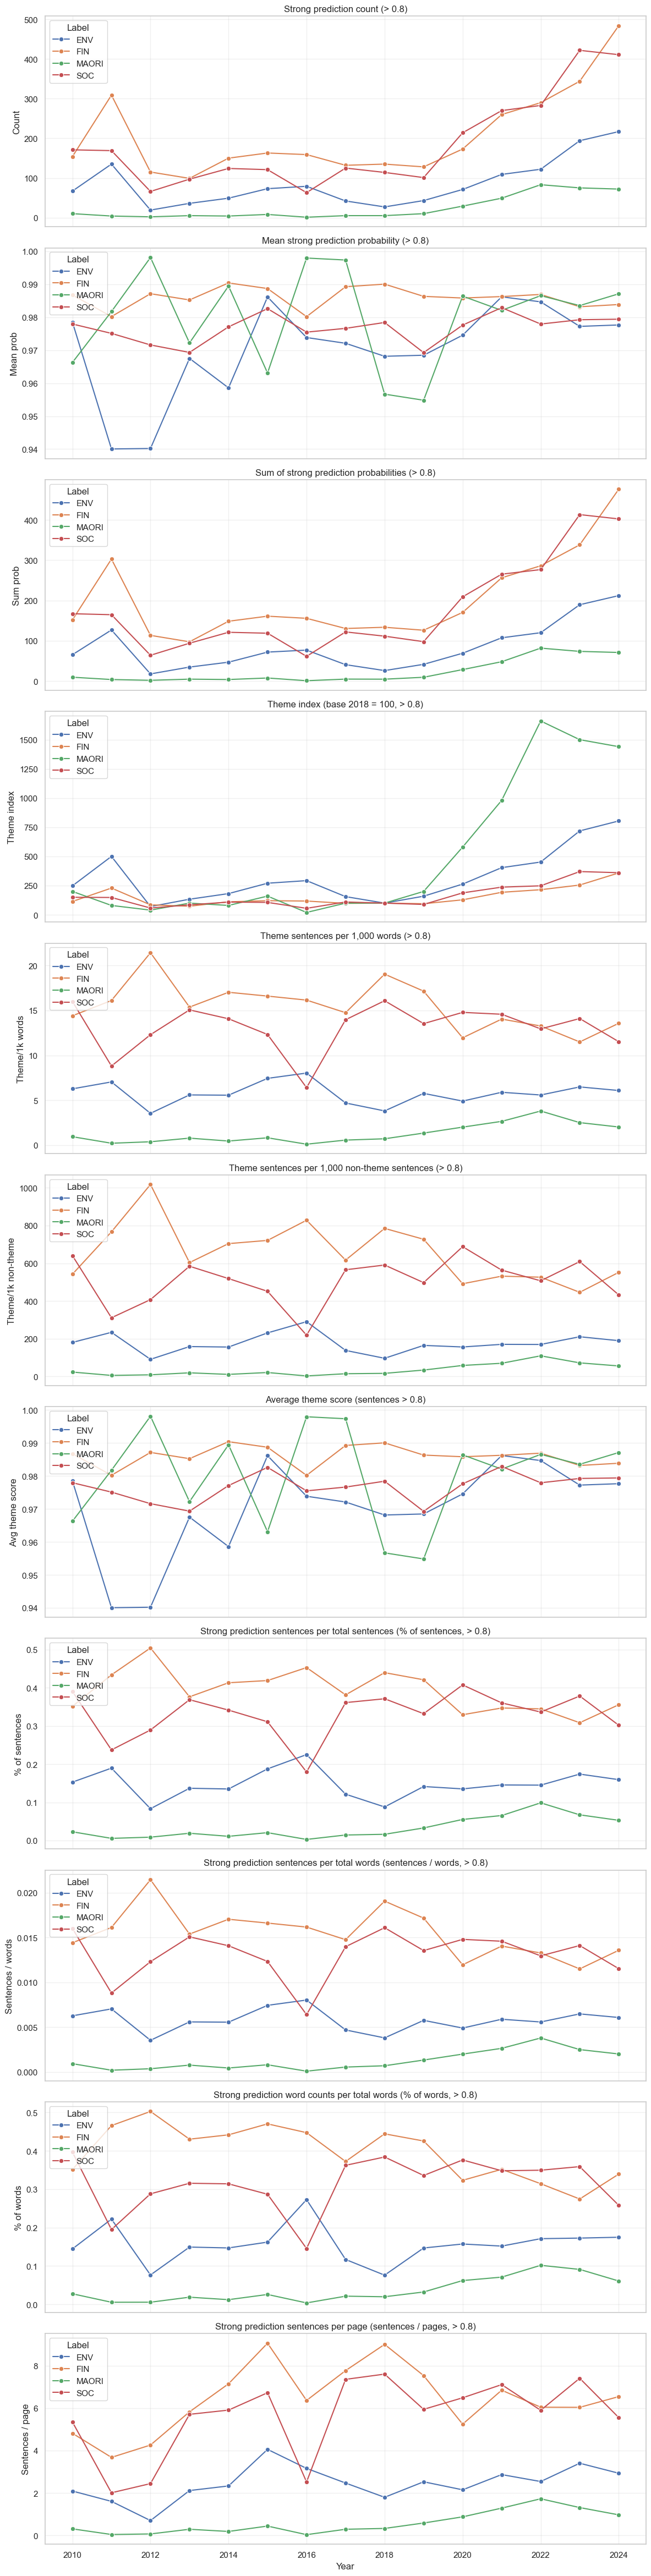

In [9]:
# Combined view for threshold > 0.8 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.8)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.8)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.8)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.8)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.8)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.8)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.8)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.8)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.8)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.8)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.8)"),
]
summary = summaries[0.8]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


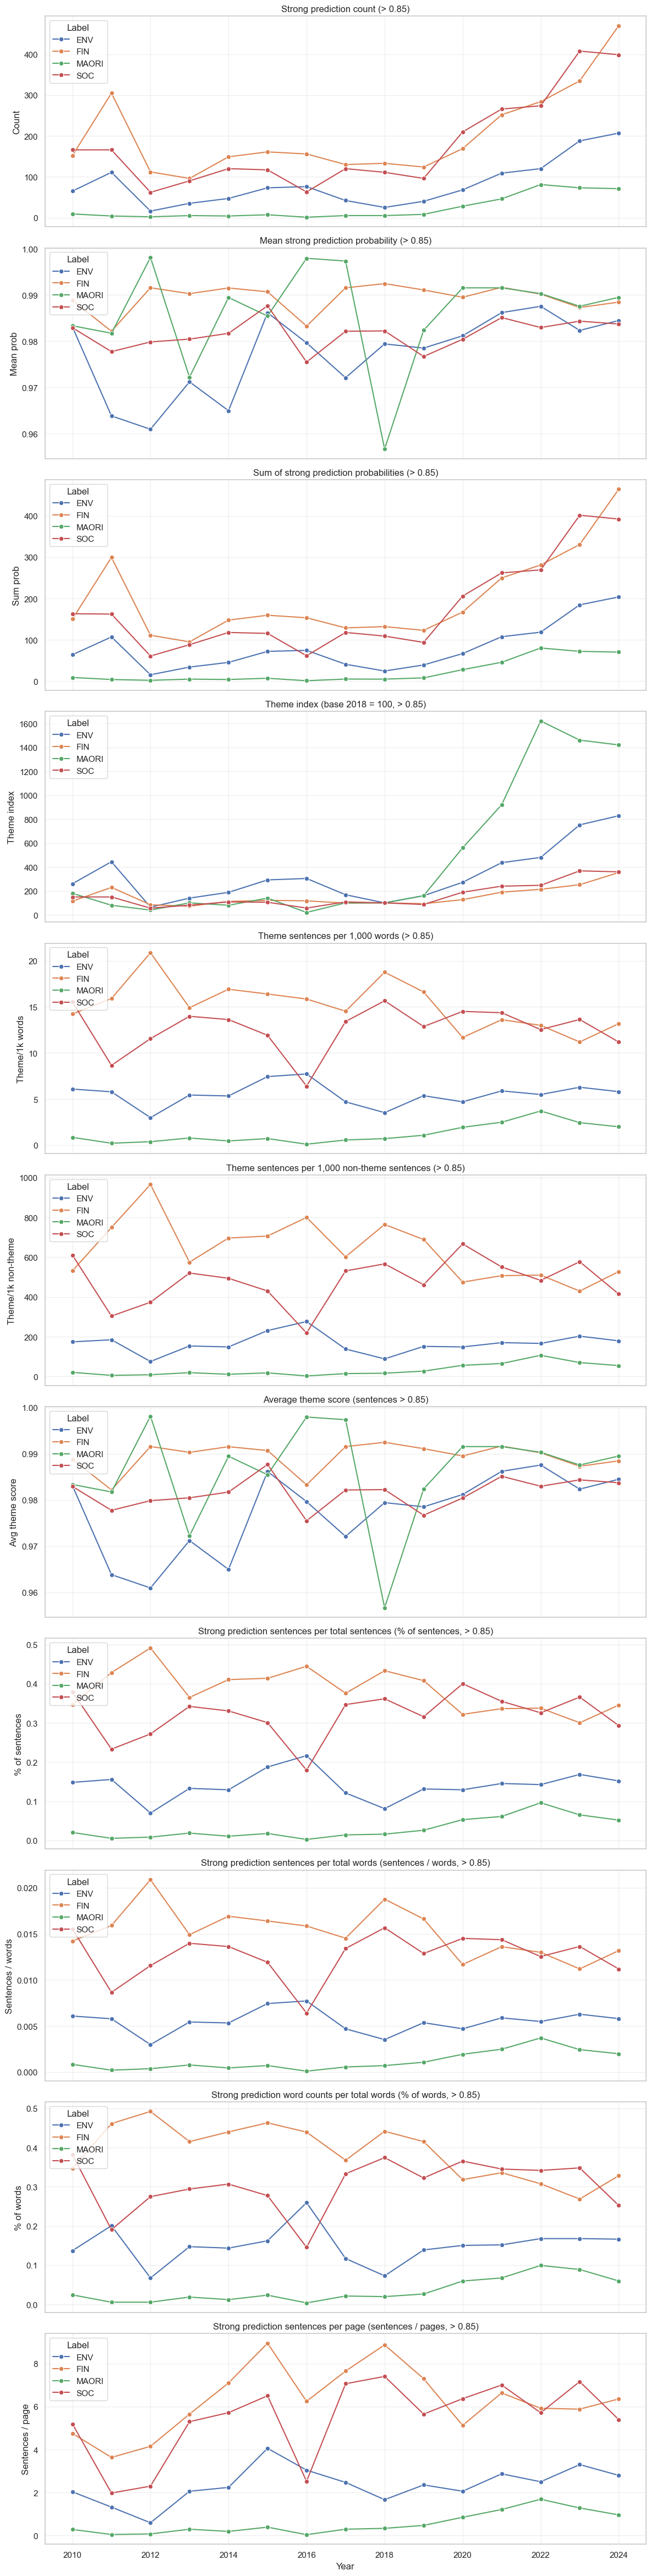

In [10]:
# Combined view for threshold > 0.85 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.85)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.85)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.85)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.85)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.85)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.85)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.85)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.85)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.85)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.85)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.85)"),
]
summary = summaries[0.85]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


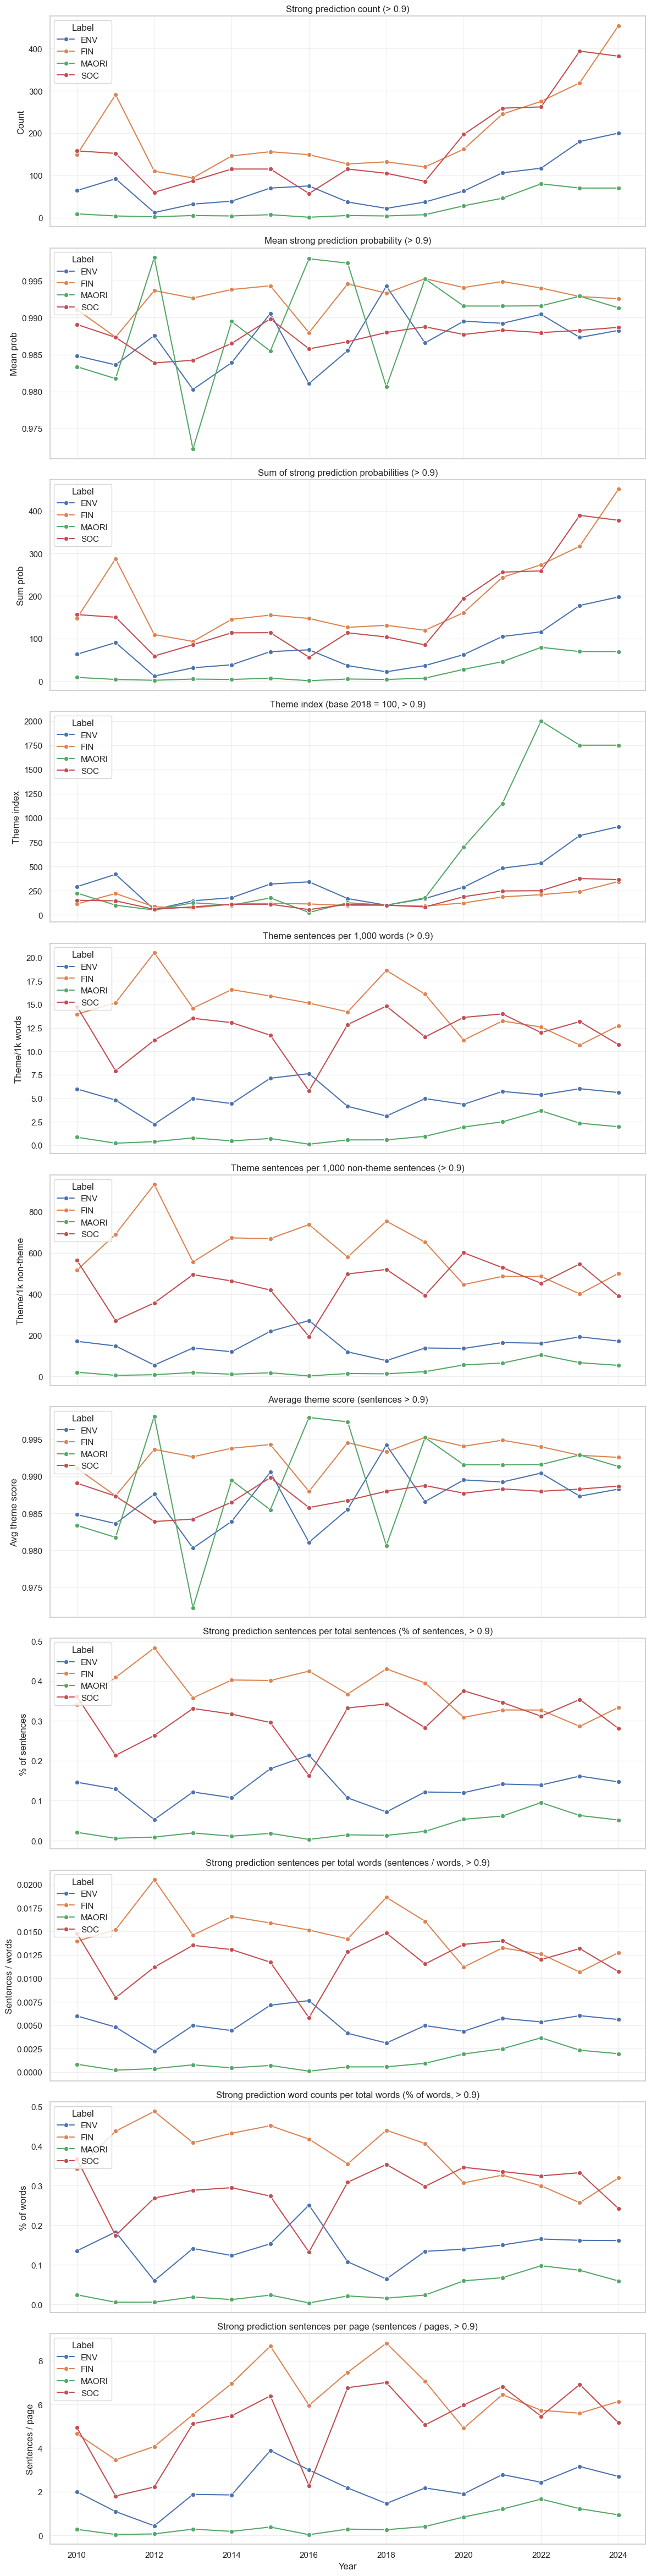

In [11]:
# Combined view for threshold > 0.9 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.9)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.9)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.9)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.9)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.9)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.9)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.9)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.9)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.9)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.9)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.9)"),
]
summary = summaries[0.9]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


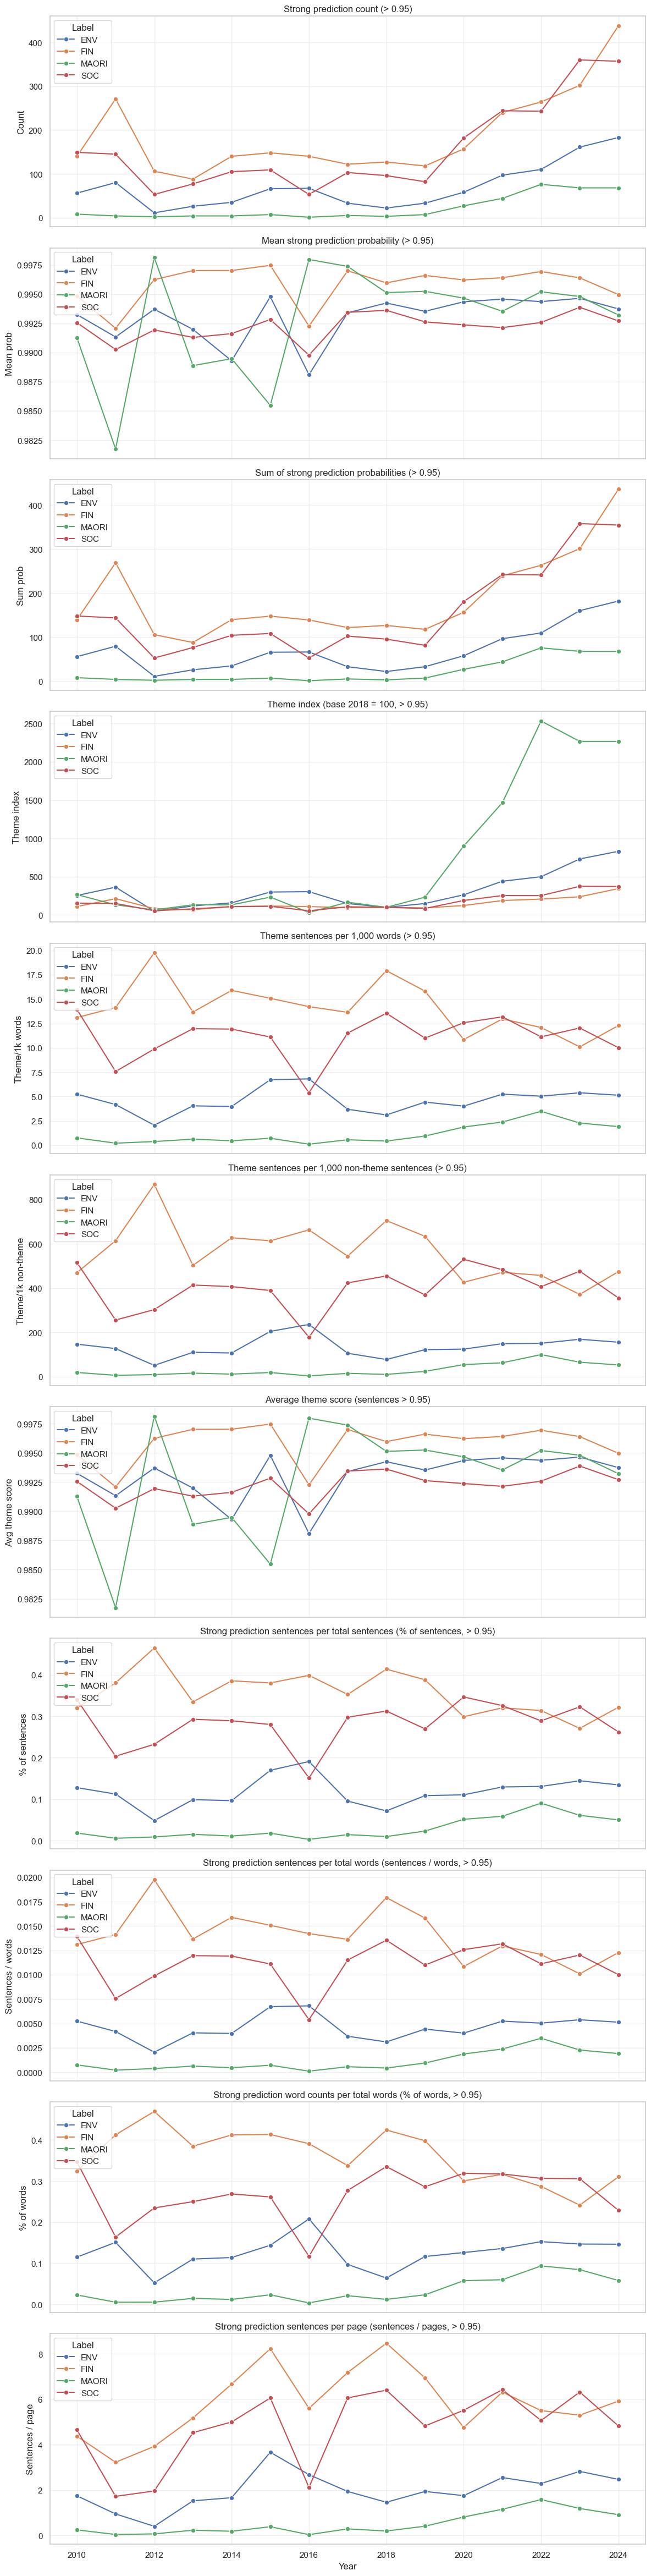

In [12]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.95)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.95)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.95)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.95)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.95)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.95)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.95)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.95)"),
]
summary = summaries[0.95]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
